In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, SMOTENC

import pickle

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [3]:
data = pd.read_csv('src/fraud test.csv')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [6]:
def data_cleanse(data_sample):
    '''On retire les colonnes qui ne sont pas pertinentes
        cc_num, trans_num, first, last et {city, state, street, zip} = infos individuelles trop de valeurs différentes
        merchant = idem
        Unnamed: 0 = index, des identifiants donc à supprimer
        unix_time = temps Unix, redondant'''
    colonne_a_retirer = ['cc_num', 'first', 'last', 'city', 'state', 'street', 'zip', 'trans_num', 'Unnamed: 0', 'merchant', 'unix_time', 'lat', 'long']
    df = data_sample.drop(colonne_a_retirer, axis=1)
    df["trans_date_trans_time"]=pd.to_datetime(df["trans_date_trans_time"], format= "%d/%m/%Y %H:%M")
    df["dob"]=pd.to_datetime(df["dob"], format= "%d/%m/%Y")

    annee_actuelle = pd.Timestamp.now().year
    df['age'] = annee_actuelle - df["dob"].dt.year

    df["day_of_the_week"]=df["trans_date_trans_time"].dt.weekday
    df["month"]=df["trans_date_trans_time"].dt.month
    df["day"]=df["trans_date_trans_time"].dt.day
    df["year"]=df["trans_date_trans_time"].dt.year
    df["hour"]=df["trans_date_trans_time"].dt.hour

    colonne_a_retirer = ['trans_date_trans_time', 'dob']
    df = df.drop(colonne_a_retirer, axis=1)
    return df

In [7]:
df = data_cleanse(data)

In [8]:
# Sélection des colonnes
selected_columns = ['category', 'gender', 'age', 'hour', 'day', 'month',
                    'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long', 'amt', 'is_fraud']
data_selected = df[selected_columns]

In [9]:
# Pour l'ensemble de test, sélectionnez 3 lignes avec 'is_fraud' à 1 et 3 lignes avec 'is_fraud' à 0
test_fraud = data_selected[data_selected['is_fraud'] == 1].sample(50, random_state=42)
test_non_fraud = data_selected[data_selected['is_fraud'] == 0].sample(100, random_state=42)
data_test = pd.concat([test_fraud, test_non_fraud]).sample(frac=1., random_state=42)
X_test = data_test.drop('is_fraud', axis=1)
y_test = data_test['is_fraud']

In [10]:
# Pour l'ensemble d'entraînement, prenez le reste des données
data_train = data_selected.drop(data_test.index)

In [17]:
# Sauvegarde des dataframes dans des fichiers CSV
data_train.to_csv('src/train.csv', index=False)
X_test.to_csv('test.csv', index=False)
data_test.to_csv('test_sol.csv', index=False)

In [8]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'hour', 'day', 'month', 'day_of_the_week', 'city_pop', 'merch_lat', 'merch_long', 'amt']
features = categorical_features + numerical_features
target = 'is_fraud'

X = data_train.loc[:,features]
y = data_train.loc[:,target]

In [10]:
# Définition des transformations

categorical_transformer = OneHotEncoder(drop="first")

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

smotenc = SMOTENC(categorical_features=[0, 1])

# Train test split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=0, stratify=y)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

X_train, y_train = smotenc.fit_resample(X_train, y_train)

In [11]:
X_val[0:5]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        , -1.12670322,
        -1.29267332, -0.16358219, -0.25628022, -0.79130264, -0.19107778,
         0.33972505,  1.16364295,  0.09423275],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        , -0.15033911,
        -0.85216128, -1.61570402, -0.25628022, -0.33224319, -0.28844371,
         1.0598514 , -1.36264113, -0.1898569 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        , -1.24156959,
        -0.70532393, -0.94549394,  0.75480141,  1.50399464, -0.27380121,
         0.94003574,  1.4681

In [21]:
X_test.head()

,category,gender,age,hour,day,month,day_of_the_week,city_pop,merch_lat,merch_long,amt
306609,shopping_net,M,62,7,15,10,3,1766,42.106837,-78.094864,5.84
309948,grocery_pos,M,74,2,17,10,5,43102,38.638158,-76.891253,285.80
66005,health_fitness,F,49,23,13,7,0,5895,43.455696,-73.620501,5.70
394310,grocery_net,F,35,3,23,11,0,2368,39.236557,-94.453812,28.76
477777,food_dining,M,20,17,14,12,0,817312,42.122950,-88.877977,87.10


In [22]:
y_test.head()

306609    0
309948    1
66005     0
394310    0
477777    0
Name: is_fraud, dtype: int64

In [19]:
# Obtenez les noms des features après le prétraitement
onehot_features = preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_features)
#numeric_features = numerical_features  # Ces noms restent les mêmes
feature_names = np.concatenate([onehot_features, numerical_features])

X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), index=X_test.index, columns=feature_names)
X_test_transformed.head()

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,...,gender_M,age,hour,day,month,day_of_the_week,city_pop,merch_lat,merch_long,amt
306609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.653725,-0.852161,-0.163582,0.249261,0.126816,-0.288039,0.698266,0.882824,-0.398377
309948,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.342924,-1.586348,0.059821,0.249261,1.044935,-0.149851,0.017919,0.970297,1.357334
66005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.092906,1.497236,-0.386986,-1.267362,-1.250362,-0.274236,0.962832,1.207999,-0.399255
394310,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.896970,-1.439511,0.730031,0.754801,-1.250362,-0.286027,0.135289,-0.306064,-0.254639
477777,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.758468,0.616212,-0.275284,1.260342,-1.250362,2.438361,0.701427,0.099161,0.111228


In [23]:
# Ajoutez la colonne y_test au dataframe transformed
data_test_transformed = X_test_transformed.copy()
data_test_transformed['is_fraud'] = y_test.values
data_test_transformed.head()

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,...,age,hour,day,month,day_of_the_week,city_pop,merch_lat,merch_long,amt,is_fraud
306609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.653725,-0.852161,-0.163582,0.249261,0.126816,-0.288039,0.698266,0.882824,-0.398377,0
309948,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.342924,-1.586348,0.059821,0.249261,1.044935,-0.149851,0.017919,0.970297,1.357334,1
66005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.092906,1.497236,-0.386986,-1.267362,-1.250362,-0.274236,0.962832,1.207999,-0.399255,0
394310,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.896970,-1.439511,0.730031,0.754801,-1.250362,-0.286027,0.135289,-0.306064,-0.254639,0
477777,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.758468,0.616212,-0.275284,1.260342,-1.250362,2.438361,0.701427,0.099161,0.111228,0


In [24]:
# Enregistrez le DataFrame dans un fichier CSV
X_test_transformed.to_csv('test_pr.csv', index=False)
data_test_transformed.to_csv('test_pr_sol.csv', index=False)

In [19]:
# Déclaration du modèle

classifier_xgb = XGBClassifier()

# Définition des paramètres du gridsearch

params = {
    "max_depth": [2, 6, 10, 15],
    "min_child_weight": [1, 2, 3, 4, 5, 6],
    "n_estimators": [4, 8, 12, 16, 20]
}

# Gridsearch

print("Grid search...")
gridsearch_xgb = GridSearchCV(
    classifier_xgb, param_grid=params, cv=3, scoring='f1'
)
gridsearch_xgb.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_xgb.best_params_)
print("Best validation F1-score : ", gridsearch_xgb.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 20}
Best validation F1-score :  0.999077690797721


In [20]:
y_train_pred = gridsearch_xgb.predict(X_train)
y_val_pred = gridsearch_xgb.predict(X_val)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    387432
           1       1.00      1.00      1.00    387432

    accuracy                           1.00    774864
   macro avg       1.00      1.00      1.00    774864
weighted avg       1.00      1.00      1.00    774864

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    166042
           1       0.77      0.84      0.80       629

    accuracy                           1.00    166671
   macro avg       0.88      0.92      0.90    166671
weighted avg       1.00      1.00      1.00    166671



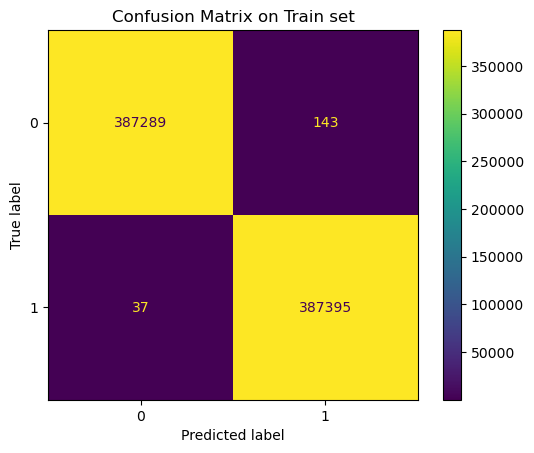

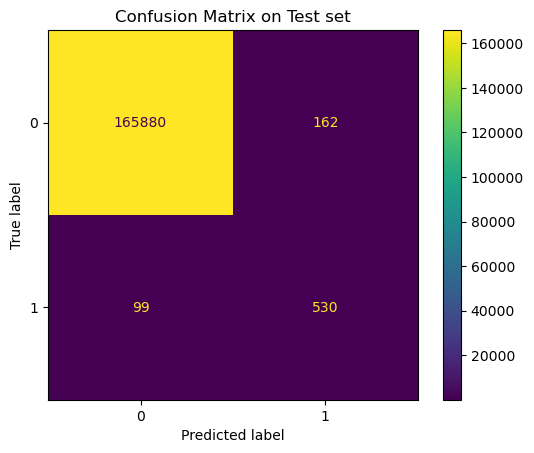

In [21]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_xgb, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_xgb, X_val, y_val, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [27]:
preprocessor

ColumnTransformer(transformers=[('categorical', OneHotEncoder(drop='first'),
                                 ['category', 'gender']),
                                ('numerical', StandardScaler(),
                                 ['age', 'hour', 'day', 'month',
                                  'day_of_the_week', 'city_pop', 'merch_lat',
                                  'merch_long', 'amt'])])

In [22]:
with open('xgboost.pkl', 'wb') as f:
    pickle.dump(gridsearch_xgb, f)

In [28]:
with open('preprocess.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [4]:
def load_model():
    with open('xgboost.pkl', 'rb') as f:
        model = pickle.load(f)
    return model

In [5]:
def load_preprocessor():
    with open('preprocess.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    return preprocessor

In [31]:
model = load_model()

In [32]:
model

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [2, 6, 10, 15],
                         'min_child_weight': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [4, 8, 12, 16, 20]},
             scoring='f1')

In [11]:
TEST_URL = ('test.csv')
REAL_URL = ('test_sol.csv')

def load_test():
    data = pd.read_csv(TEST_URL)
    return data

def load_sol():
    data = pd.read_csv(REAL_URL)
    return data

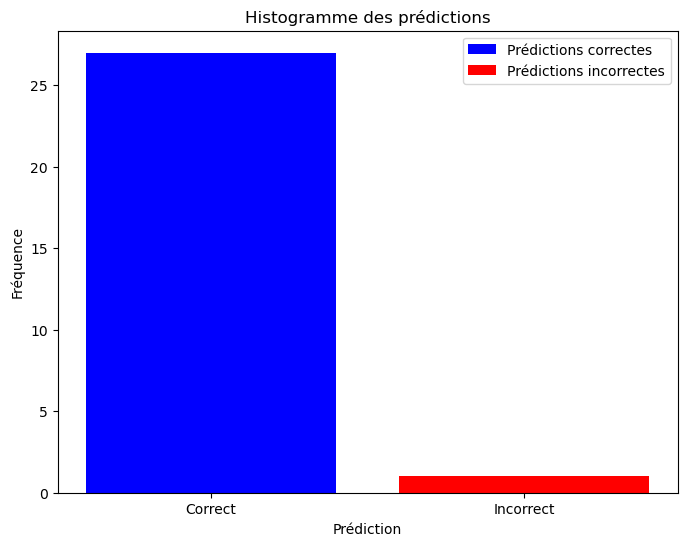

In [43]:
pred = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])
real = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

# Calculez si chaque prédiction est correcte ou non
pred_correct = (pred == real).astype(int)

# Comptez le nombre de prédictions correctes et incorrectes
correct_count = np.sum(pred_correct)
incorrect_count = len(pred_correct) - correct_count

# Créez un histogramme avec deux barres de couleurs différentes
plt.figure(figsize=(8, 6))
plt.bar(1, correct_count, color='blue', label='Prédictions correctes')
plt.bar(2, incorrect_count, color='red', label='Prédictions incorrectes')

# Définissez les labels de l'axe des x pour correspondre aux classes
plt.xticks([1, 2], ['Correct', 'Incorrect'])

# Ajoutez des labels et une légende
plt.xlabel('Prédiction')
plt.ylabel('Fréquence')
plt.legend(loc='upper right')
plt.title('Histogramme des prédictions')
plt.show()

In [13]:
test = load_test()
test.head()

,category,gender,age,hour,day,month,day_of_the_week,city_pop,merch_lat,merch_long,amt
0,shopping_net,M,62,7,15,10,3,1766,42.106837,-78.094864,5.84
1,grocery_pos,M,74,2,17,10,5,43102,38.638158,-76.891253,285.80
2,health_fitness,F,49,23,13,7,0,5895,43.455696,-73.620501,5.70
3,grocery_net,F,35,3,23,11,0,2368,39.236557,-94.453812,28.76
4,food_dining,M,20,17,14,12,0,817312,42.122950,-88.877977,87.10


In [15]:
index = 38
line = test.iloc[38,:]

In [18]:
display(line)

category           shopping_net
gender                        F
age                          41
hour                          3
day                          27
month                         9
day_of_the_week               6
city_pop                  59705
merch_lat             33.782994
merch_long          -118.279099
amt                     1030.02
Name: 38, dtype: object

In [24]:
pd.DataFrame(line).T

,category,gender,age,hour,day,month,day_of_the_week,city_pop,merch_lat,merch_long,amt
38,shopping_net,F,41,3,27,9,6,59705,33.782994,-118.279099,1030.02


In [29]:
def load_preprocessor():
    with open('preprocess.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    return preprocessor

preprocessor = load_preprocessor()

line = test.iloc[38,:]

line_df = pd.DataFrame(line).T

line_pr = preprocessor.transform(line_df)

line_pr[0:5]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        , -0.55237139,
        -1.43951067,  1.17683796, -0.25628022,  1.50399464, -0.09434703,
        -0.93437252, -2.03756858,  6.02455705]])

In [1]:
import pickle

def load_model():
    with open('xgboost.pkl', 'rb') as f:
        model = pickle.load(f)
    return model

def load_preprocessor():
    with open('preprocess.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    return preprocessor

model = load_model()
preprocessor = load_preprocessor()


In [16]:
import pandas as pd
import plotly.express as px

column_names = []
for (
    name,
    step,
    features_list,
) in preprocessor.transformers_:  # loop over steps of ColumnTransformer
    if name == "numerical":  # if pipeline is for numeric variables
        features = (
            features_list  # just get the names of columns to which it has been applied
        )
    else:  # if pipeline is for categorical variables
        features = (
            step.get_feature_names_out()
        )  # get output columns names from OneHotEncoder
    column_names.extend(features)  # concatenate features names

# Create a pandas DataFrame
feature_importance = pd.DataFrame(
    index=column_names,
    data=model.best_estimator_.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances", ascending = False).reset_index()
feature_importance.rename(columns={'index': 'Feature', 'feature_importances' : 'Coefficient'}, inplace=True)

feature_importance.head()

,Feature,Coefficient
0,category_gas_transport,0.239059
1,amt,0.232384
2,hour,0.091556
3,category_grocery_net,0.071965
4,category_travel,0.049140


In [17]:
feature_importance.to_csv('feature_importance.csv')

In [35]:
feature_importance = pd.read_csv('Streamlit/feature_importance.csv')

In [36]:
feature_importance.head()

,Unnamed: 0,Feature,Coefficient
0,0,category_gas_transport,0.239059
1,1,amt,0.232384
2,2,hour,0.091556
3,3,category_grocery_net,0.071965
4,4,category_travel,0.049140


In [43]:
feature_importance = pd.read_csv('Streamlit/feature_importance.csv')
# Plot coefficients
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=True)
fig = px.histogram(feature_importance, y='Feature', x='Coefficient')
fig.update_layout(
    showlegend=False, margin={"l": 120}, height=600,  # to avoid cropping of column names
    xaxis_title_text='Coefficient', yaxis_title_text='Feature'
)
fig.show()